<a href="https://colab.research.google.com/github/khaledlarbi/MVA_MGI/blob/main/Generative_Models_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MVA - Generative Models Project** - "Tackling the Generative Learning Trilemma with Denoising Diffusion GANs"

Solène Blasco Lopez - solene.blascolopez@ensae.fr

Khaled Larbi - khaled.larbi@ensae.fr

---

<blockquote>

*BROUILLON / IDEES :*

* Implémentation : GAN simple et Denoising Diffusion GAN (et éventuellement Diffusion Model ?) 
  * Pour le code DDGAN, il y a une version ici : https://github.com/NVlabs/denoising-diffusion-gan, mais les fonctions sont faites uniquement pour train sur CIFAR-10 & Stacked-MNIST, il faudra qu'on modifie les fonctions de train et de test pour prendre en charge d'autres datasets, ou alors on le recode...
  - Pour les GANs, il y a tout un tas d'exemples ici : https://github.com/caogang/wgan-gp/tree/ae47a185ed2e938c39cf3eb2f06b32dc1b6a2064     
  - Pour les DDPM, j'ai trouvé ce git qui supporte CIFAR-10 : https://github.com/w86763777/pytorch-ddpm ; sinon j'ai trouvé un git qui a l'air facile à réutiliser avec n'importe quel dataset : https://github.com/lucidrains/denoising-diffusion-pytorch
* Experiments :     
    - mode coverage on multimodal gaussian (25-Gaussian dataset, comme dans leur figure 6) or StackedMNIST 
    - MNIST (+ éventuellement regarder la possibilité d'interpolation avec les modèles ? Comme ce que l'on avait vu un peu dans la présentation des VAE il me semble) 
* Possibilités extensions :    
    - ils évoquent ne pas avoir testé avec des $\beta_t$ "non equidistant" par rapport à ceux qu'ils ont choisi
    - ils disent avoir essayé de remplacer les conditional GAN par des conditional VAE mais que ça avait moins bien marché à première vue
    - passage/lien avec la théorie continue ? Mais en soit comme on fait des pas plus grands avec le modèle de l'article cela n'a peut être plus trop de sens

</blockquote>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Toy example : 25-Gaussian dataset in two dimensions

The following function is inspired from : https://github.com/caogang/wgan-gp/blob/master/gan_toy.py

In [4]:
def generate_25_gaussian_dataset (size = 5_000) : 
        dataset = []

        # Generate size //25 samples for each possible mean position :
        for x in range(-2, 3):
            for y in range(-2, 3):
                # Generate size //25 samples with mean (x,y) :
                for i in range(size //25):
                    point = np.random.randn(2) * 0.05
                    point[0] += 2 * x
                    point[1] += 2 * y
                    dataset.append(point)
        dataset = np.array(dataset, dtype='float32')
        dataset /= 2.828  # stdev

        # Return shuffled dataset : 
        np.random.shuffle(dataset)
        return torch.from_numpy(dataset)

In [5]:
def plot_2d (points, title=None, x_lim=(-1.7,1.7), y_lim=(-1.7,1.7), figsize=(4,4)) :
    # Points of shape : nb_points x 2
    plt.figure(figsize=figsize)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    if title is not None :
        plt.title(title)
    plt.scatter(points[:,0], points[:,1])
    plt.show()

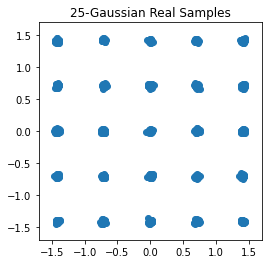

In [6]:
points = generate_25_gaussian_dataset(size=1_000)
plot_2d(points, title="25-Gaussian Real Samples")

### GAN :

#### Implementation & Training :

> The following implementation and choice of parametrization is inspired from : https://github.com/caogang/wgan-gp/blob/master/gan_toy.py

In [ ]:
class Generator(nn.Module):

    def __init__(self, hidden_dim=512, latent_dim=2, device=device):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 2),
        ).to(device)

        self.latent_dim = latent_dim

    def forward(self, noise):
        return self.generator(noise) 

    def generate(self, nb_samples):
        noise = torch.rand(nb_samples, self.latent_dim, device=device)
        return self.forward(noise)


class Discriminator(nn.Module):

    def __init__(self, hidden_dim=512, device=device):
        super(Discriminator, self).__init__()

        self.discriminator = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, 1),  
        )

    def forward (self, inputs):
        return self.discriminator(inputs).view(-1)

In [ ]:
def training_gan_25gaussian (generator, discriminator, optimizer_generator, optimizer_discriminator, nb_epochs, train_ratio = 5, batch_len=500, criterion=nn.BCEWithLogitsLoss(), device=device, display_step=500) :
    # train_ratio : number of training of the discriminator for 1 train of the generator

    # Elements to keep track of losses : 
    generator_losses = []
    discriminator_losses = []

    # Generated ground truths 0 and 1 :
    ground_truth_0 = torch.zeros(batch_len).to(device)
    ground_truth_1 = torch.ones(batch_len).to(device)

    # Training :
    for epoch in tqdm(range(nb_epochs)) :  

            # Discriminator training : (train_ratio times)
            # -----------------------

            for d_param in discriminator.parameters():  
                d_param.requires_grad = True

            for _ in range(train_ratio) :

                optimizer_discriminator.zero_grad()

                # Performance of discriminator on fake/generated images :
                generated_images = generator.generate(batch_len).detach()
                discriminator_fake_loss = criterion(discriminator(generated_images), ground_truth_0)

                # Performance of discriminator on some real images :
                real_images = generate_25_gaussian_dataset(batch_len).to(device)
                discriminator_real_loss = criterion(discriminator(real_images), ground_truth_1)


                # Total loss : 
                discriminator_loss = (discriminator_fake_loss + discriminator_real_loss) / 2
                discriminator_losses.append(discriminator_loss.item())

                # Backpropagation : 
                discriminator_loss.backward()
                optimizer_discriminator.step()

            # Generator training :
            # -------------------

            # Froze the discriminator's parameters :
            for d_param in discriminator.parameters():  
                d_param.requires_grad = False

            optimizer_generator.zero_grad()

            # Generate fake images : 
            generated_images = generator.generate(batch_len)

            # Computation of generator's loss, considering the fact that it's 
            # goal is to have the discriminator predicting ones on generated images :
            generator_loss = criterion(discriminator(generated_images), ground_truth_1)
            generator_losses.append(generator_loss.item())

            # Backpropagation : 
            generator_loss.backward()
            optimizer_generator.step()


            # Plot of losses and some generated images during training :
            if epoch % display_step == 0 :
                    print(f'\n Epoch {epoch} : Gen loss : {generator_losses[-1]:.4f} || Disc loss : {discriminator_losses[-1]:.4f} ')

                    generated_images = generator.generate(batch_len).detach().cpu().numpy()
                    plot_2d(generated_images)


    # Plot of losses during the training :
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot([i*train_ratio for i in range(len(generator_losses))], generator_losses, label="Generator")
    plt.plot(discriminator_losses,label="Discriminator")
    plt.xlabel("Updates")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# Setting parameters :
hidden_dim = 256
latent_dim = 2

nb_epochs = 5_001
lr = 0.0001

# Creation of the model & their optimizers : 
generator = Generator(hidden_dim=hidden_dim, latent_dim=latent_dim, device=device)
discriminator = Discriminator(hidden_dim=hidden_dim).to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

  0%|          | 0/5001 [00:00<?, ?it/s]


 Epoch 0 : Gen loss : 0.7295 || Disc loss : 0.6628 


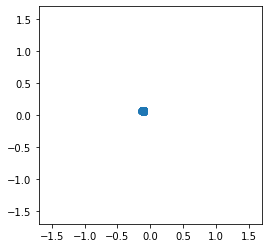


 Epoch 500 : Gen loss : 4.0104 || Disc loss : 0.1648 


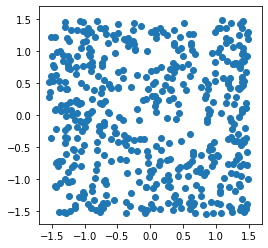


 Epoch 1000 : Gen loss : 5.3483 || Disc loss : 0.1365 


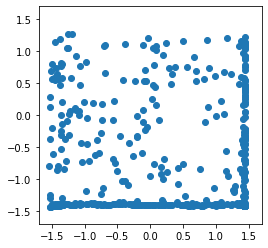


 Epoch 1500 : Gen loss : 5.1111 || Disc loss : 0.1345 


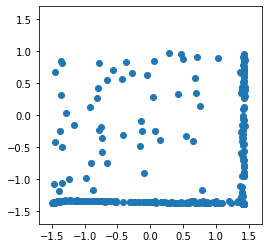


 Epoch 2000 : Gen loss : 3.8760 || Disc loss : 0.1776 


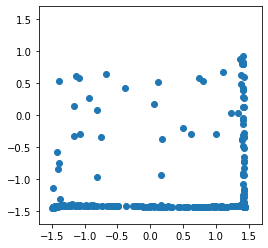


 Epoch 2500 : Gen loss : 4.6884 || Disc loss : 0.1756 


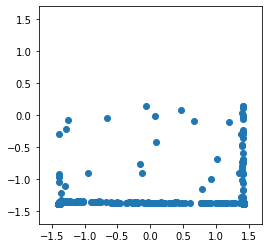


 Epoch 3000 : Gen loss : 3.4732 || Disc loss : 0.0954 


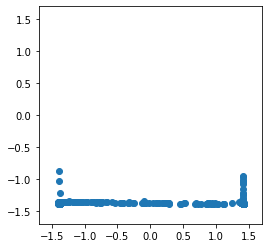


 Epoch 3500 : Gen loss : 3.7454 || Disc loss : 0.1089 


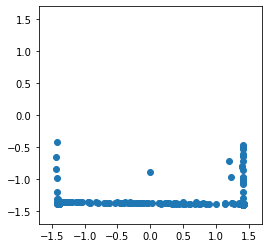


 Epoch 4000 : Gen loss : 3.1587 || Disc loss : 0.1090 


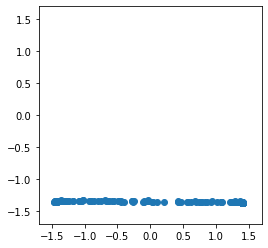


 Epoch 4500 : Gen loss : 4.0311 || Disc loss : 0.1794 


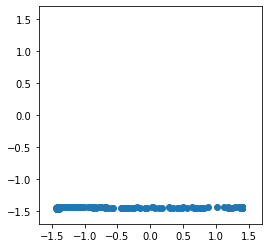


 Epoch 5000 : Gen loss : 2.5423 || Disc loss : 0.1248 


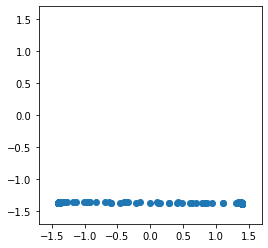

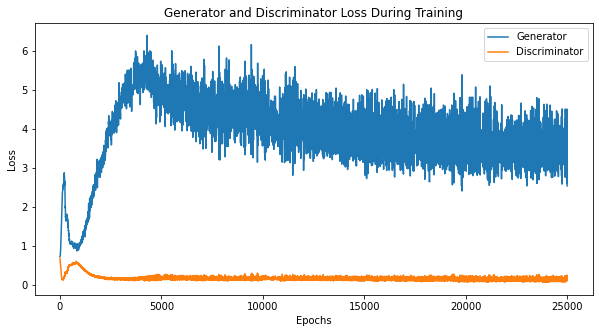

In [ ]:
# Training : 
training_gan_25gaussian(generator, discriminator, optimizer_generator, optimizer_discriminator, nb_epochs)

## MNIST dataset  

In [ ]:
# Load dataset :
batch_size = 128
dataset_mnist = datasets.MNIST('.',download=True,transform=transforms.ToTensor())
dataloader_mnist =  DataLoader(dataset=dataset_mnist, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# Util visualization function from one of our TP : 
# Given a tensor of images, number of images and size per image, this function plots and prints the images on a uniform grid 

from torchvision.utils import make_grid
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

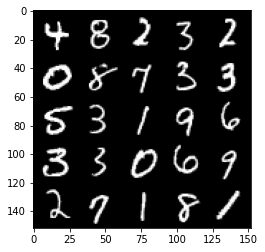

In [ ]:
images, _ = next(iter(dataloader_mnist))
show_tensor_images(images)

### GAN :

#### Implementation & Training :

> Implementation inspired from one of our TP & https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py 

In [ ]:
class Generator(nn.Module):

    def __init__(self, latent_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim

        def block(in_feat, out_feat, normalize=True):
                layers = [nn.Linear(in_feat, out_feat)]
                if normalize:
                    layers.append(nn.BatchNorm1d(out_feat, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

        self.gen = nn.Sequential(
                *block(latent_dim, hidden_dim), #, normalize=False),
                *block(hidden_dim, hidden_dim*2),
                *block(hidden_dim*2, hidden_dim*4),
                *block(hidden_dim*4, hidden_dim*8),
                nn.Linear(hidden_dim*8, im_dim),
                nn.Tanh()
            )

    def forward(self, noise):
        return self.gen(noise)

    def generate(self, nb_samples):
        noise = torch.rand(nb_samples,self.latent_dim, device=device)
        return self.forward(noise)


class Discriminator(nn.Module):
    def __init__(self, im_dim=764, hidden_dim=128):
        super(Discriminator, self).__init__()

        self.disc = nn.Sequential(
            nn.Linear(im_dim, hidden_dim*4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Linear(hidden_dim,1),
            # nn.Sigmoid(),
        )

    def forward(self, image):
        return self.disc(image)

In [ ]:
def training_gan (dataloader, generator, discriminator, optimizer_generator, optimizer_discriminator, nb_epochs, train_ratio = 5, criterion=nn.BCEWithLogitsLoss(), device=device, display_step=10) :

    # Elements to keep track of losses : 
    generator_losses = []
    discriminator_losses = []

    # Training :
    for epoch in range(nb_epochs) : 

        mean_generator_loss = 0
        mean_discriminator_loss = 0

        for images, _ in tqdm(dataloader) :
            nb_images = len(images)
            real_images = images.view(nb_images, -1).to(device)
            
            # Generated ground truths 0 and 1 :
            ground_truth_0 = torch.zeros(nb_images,1).to(device)
            ground_truth_1 = torch.ones(nb_images,1).to(device)

            # Generator training :
            # -------------------
            for d_param in discriminator.parameters():  
                d_param.requires_grad = False
            optimizer_generator.zero_grad()

            # Generate images from a sampled noise : 
            generated_images = generator.generate(nb_images)

            # Computation of generator's loss, considering the fact that it's 
            # goal is to have the discriminator predicting ones on generated images :
            generator_loss = criterion(discriminator(generated_images), ground_truth_1)
            mean_generator_loss += generator_loss.item() 

            # Backpropagation : 
            generator_loss.backward()
            optimizer_generator.step()

            # Discriminator training : 
            # -----------------------
            for d_param in discriminator.parameters():  
                d_param.requires_grad = True
            optimizer_discriminator.zero_grad()

            # Performance of discriminator on fake/generated images :
            generated_images = generator.generate(nb_images).detach()
            discriminator_fake_loss = criterion(discriminator(generated_images), ground_truth_0)

            # Performance of discriminator on real images :
            discriminator_real_loss = criterion(discriminator(real_images), ground_truth_1)

            # Total loss : 
            discriminator_loss = (discriminator_fake_loss + discriminator_real_loss) / 2
            mean_discriminator_loss += discriminator_loss.item()

            # Backpropagation : 
            discriminator_loss.backward()
            optimizer_discriminator.step()

        generator_losses.append(mean_generator_loss / len(dataloader))
        discriminator_losses.append(mean_discriminator_loss / len(dataloader))
        print(f'\n Epoch {epoch} : Gen loss : {generator_losses[-1]:.4f} || Disc loss : {discriminator_losses[-1]:.4f} ')


        # Plot of some generated images during training :
        if epoch % display_step == 0 :
                generated_images = generator.generate(nb_images).detach()
                show_tensor_images(generated_images)

    # Plot of losses during the training :
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(generator_losses, label="Generator")
    plt.plot(discriminator_losses,label="Discriminator")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
# Setting parameters :
im_dim = 784
hidden_dim = 128
latent_dim = 64

nb_epochs = 201
lr = 0.00001

# Creation of the model & their optimizers : 
generator = Generator(latent_dim, im_dim, hidden_dim).to(device)
discriminator = Discriminator(im_dim, hidden_dim).to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 0 : Gen loss : 0.6091 || Disc loss : 0.5600 


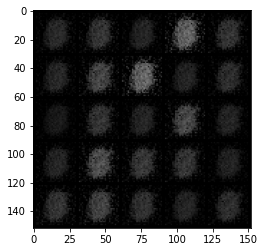

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 1 : Gen loss : 0.6935 || Disc loss : 0.6255 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 2 : Gen loss : 0.9937 || Disc loss : 0.4597 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 3 : Gen loss : 1.0815 || Disc loss : 0.4008 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 4 : Gen loss : 1.1722 || Disc loss : 0.3866 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 5 : Gen loss : 1.2859 || Disc loss : 0.3200 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 6 : Gen loss : 1.4824 || Disc loss : 0.3074 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 7 : Gen loss : 1.6972 || Disc loss : 0.2585 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 8 : Gen loss : 1.5163 || Disc loss : 0.3574 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 9 : Gen loss : 1.5052 || Disc loss : 0.3549 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 10 : Gen loss : 1.6334 || Disc loss : 0.3160 


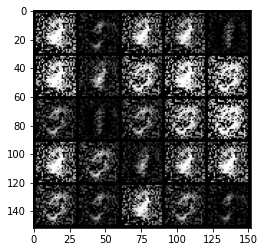

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 11 : Gen loss : 1.7826 || Disc loss : 0.2861 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 12 : Gen loss : 1.9041 || Disc loss : 0.2849 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 13 : Gen loss : 1.7596 || Disc loss : 0.3462 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 14 : Gen loss : 1.7826 || Disc loss : 0.3431 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 15 : Gen loss : 1.7849 || Disc loss : 0.3491 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 16 : Gen loss : 1.9228 || Disc loss : 0.3087 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 17 : Gen loss : 1.9456 || Disc loss : 0.2983 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 18 : Gen loss : 1.8037 || Disc loss : 0.3038 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 19 : Gen loss : 1.7239 || Disc loss : 0.3396 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 20 : Gen loss : 1.7586 || Disc loss : 0.3389 


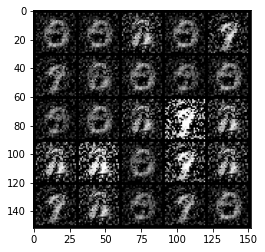

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 21 : Gen loss : 1.8572 || Disc loss : 0.3367 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 22 : Gen loss : 1.8752 || Disc loss : 0.3238 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 23 : Gen loss : 1.9395 || Disc loss : 0.3300 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 24 : Gen loss : 1.8689 || Disc loss : 0.3453 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 25 : Gen loss : 1.8551 || Disc loss : 0.3538 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 26 : Gen loss : 1.8953 || Disc loss : 0.3339 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 27 : Gen loss : 1.7832 || Disc loss : 0.3563 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 28 : Gen loss : 1.8266 || Disc loss : 0.3417 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 29 : Gen loss : 1.8054 || Disc loss : 0.3487 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 30 : Gen loss : 1.7865 || Disc loss : 0.3367 


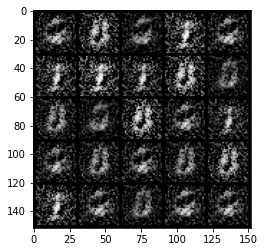

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 31 : Gen loss : 1.7966 || Disc loss : 0.3592 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 32 : Gen loss : 1.8762 || Disc loss : 0.3451 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 33 : Gen loss : 1.7580 || Disc loss : 0.4011 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 34 : Gen loss : 1.8171 || Disc loss : 0.3684 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 35 : Gen loss : 1.7879 || Disc loss : 0.3748 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 36 : Gen loss : 1.8205 || Disc loss : 0.3459 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 37 : Gen loss : 1.8639 || Disc loss : 0.3434 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 38 : Gen loss : 1.8765 || Disc loss : 0.3725 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 39 : Gen loss : 1.7850 || Disc loss : 0.3519 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 40 : Gen loss : 1.7601 || Disc loss : 0.3369 


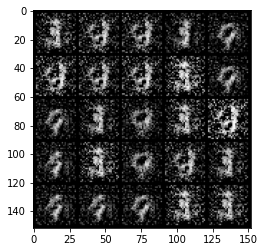

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 41 : Gen loss : 1.8278 || Disc loss : 0.3426 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 42 : Gen loss : 1.8242 || Disc loss : 0.3421 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 43 : Gen loss : 1.8244 || Disc loss : 0.3724 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 44 : Gen loss : 1.7509 || Disc loss : 0.3600 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 45 : Gen loss : 1.7799 || Disc loss : 0.3828 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 46 : Gen loss : 1.6185 || Disc loss : 0.4114 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 47 : Gen loss : 1.6461 || Disc loss : 0.4108 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 48 : Gen loss : 1.7749 || Disc loss : 0.3720 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 49 : Gen loss : 1.8337 || Disc loss : 0.3470 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 50 : Gen loss : 1.7752 || Disc loss : 0.3822 


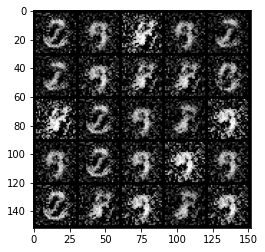

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 51 : Gen loss : 1.6810 || Disc loss : 0.3980 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 52 : Gen loss : 1.6947 || Disc loss : 0.3911 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 53 : Gen loss : 1.8444 || Disc loss : 0.3573 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 54 : Gen loss : 1.8439 || Disc loss : 0.3554 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 55 : Gen loss : 1.9206 || Disc loss : 0.3165 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 56 : Gen loss : 1.8719 || Disc loss : 0.3394 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 57 : Gen loss : 1.8997 || Disc loss : 0.3434 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 58 : Gen loss : 1.8287 || Disc loss : 0.3540 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 59 : Gen loss : 1.8696 || Disc loss : 0.3495 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 60 : Gen loss : 1.7776 || Disc loss : 0.3762 


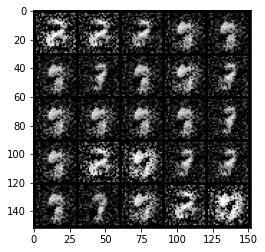

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 61 : Gen loss : 1.8777 || Disc loss : 0.3565 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 62 : Gen loss : 1.7652 || Disc loss : 0.3512 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 63 : Gen loss : 1.7871 || Disc loss : 0.3720 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 64 : Gen loss : 1.9021 || Disc loss : 0.3282 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 65 : Gen loss : 1.9269 || Disc loss : 0.3259 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 66 : Gen loss : 1.8982 || Disc loss : 0.3254 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 67 : Gen loss : 1.8479 || Disc loss : 0.3690 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 68 : Gen loss : 1.9597 || Disc loss : 0.3297 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 69 : Gen loss : 1.9528 || Disc loss : 0.3357 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 70 : Gen loss : 1.9340 || Disc loss : 0.3318 


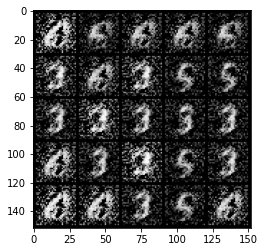

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 71 : Gen loss : 2.0453 || Disc loss : 0.3128 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 72 : Gen loss : 1.9799 || Disc loss : 0.3235 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 73 : Gen loss : 1.9083 || Disc loss : 0.3351 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 74 : Gen loss : 1.7726 || Disc loss : 0.3615 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 75 : Gen loss : 1.7333 || Disc loss : 0.3742 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 76 : Gen loss : 1.8791 || Disc loss : 0.3477 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 77 : Gen loss : 1.8735 || Disc loss : 0.3677 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 78 : Gen loss : 1.8441 || Disc loss : 0.3650 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 79 : Gen loss : 1.8600 || Disc loss : 0.3457 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 80 : Gen loss : 1.9040 || Disc loss : 0.3663 


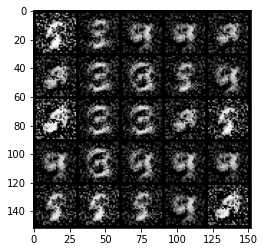

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 81 : Gen loss : 1.7902 || Disc loss : 0.3540 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 82 : Gen loss : 1.8775 || Disc loss : 0.3569 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 83 : Gen loss : 1.7713 || Disc loss : 0.3867 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 84 : Gen loss : 1.8420 || Disc loss : 0.3355 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 85 : Gen loss : 1.8795 || Disc loss : 0.3465 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 86 : Gen loss : 1.7707 || Disc loss : 0.3755 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 87 : Gen loss : 1.8244 || Disc loss : 0.3575 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 88 : Gen loss : 1.8904 || Disc loss : 0.3379 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 89 : Gen loss : 1.8974 || Disc loss : 0.3503 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 90 : Gen loss : 1.8477 || Disc loss : 0.3628 


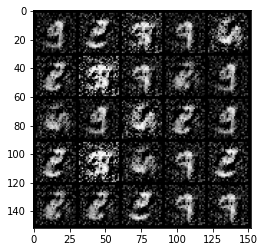

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 91 : Gen loss : 1.7643 || Disc loss : 0.3687 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 92 : Gen loss : 1.9295 || Disc loss : 0.3174 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 93 : Gen loss : 1.8449 || Disc loss : 0.3503 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 94 : Gen loss : 1.8291 || Disc loss : 0.3370 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 95 : Gen loss : 1.8721 || Disc loss : 0.3380 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 96 : Gen loss : 1.8742 || Disc loss : 0.3369 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 97 : Gen loss : 1.8940 || Disc loss : 0.3375 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 98 : Gen loss : 2.0321 || Disc loss : 0.3160 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 99 : Gen loss : 2.0483 || Disc loss : 0.2954 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 100 : Gen loss : 1.9778 || Disc loss : 0.3248 


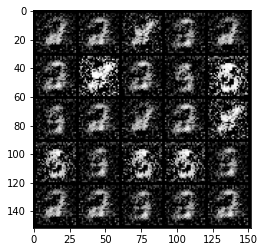

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 101 : Gen loss : 1.7560 || Disc loss : 0.3728 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 102 : Gen loss : 1.9209 || Disc loss : 0.3210 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 103 : Gen loss : 1.8719 || Disc loss : 0.3270 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 104 : Gen loss : 1.8243 || Disc loss : 0.3595 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 105 : Gen loss : 1.7462 || Disc loss : 0.3519 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 106 : Gen loss : 1.6905 || Disc loss : 0.3457 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 107 : Gen loss : 1.8317 || Disc loss : 0.3435 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 108 : Gen loss : 1.9583 || Disc loss : 0.3374 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 109 : Gen loss : 1.8849 || Disc loss : 0.3335 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 110 : Gen loss : 1.9682 || Disc loss : 0.3496 


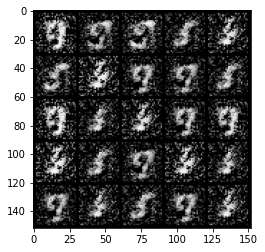

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 111 : Gen loss : 1.8963 || Disc loss : 0.3306 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 112 : Gen loss : 1.9486 || Disc loss : 0.3268 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 113 : Gen loss : 1.9861 || Disc loss : 0.3547 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 114 : Gen loss : 1.7764 || Disc loss : 0.3629 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 115 : Gen loss : 1.9164 || Disc loss : 0.3390 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 116 : Gen loss : 1.9574 || Disc loss : 0.3212 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 117 : Gen loss : 1.8711 || Disc loss : 0.3362 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 118 : Gen loss : 1.8399 || Disc loss : 0.3341 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 119 : Gen loss : 1.7505 || Disc loss : 0.3960 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 120 : Gen loss : 1.8380 || Disc loss : 0.3427 


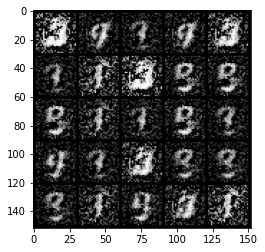

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 121 : Gen loss : 1.9361 || Disc loss : 0.3156 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 122 : Gen loss : 2.2194 || Disc loss : 0.2831 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 123 : Gen loss : 2.0888 || Disc loss : 0.2936 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 124 : Gen loss : 1.9222 || Disc loss : 0.3254 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 125 : Gen loss : 1.9415 || Disc loss : 0.2956 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 126 : Gen loss : 1.9483 || Disc loss : 0.3047 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 127 : Gen loss : 1.9853 || Disc loss : 0.3052 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 128 : Gen loss : 2.0294 || Disc loss : 0.3006 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 129 : Gen loss : 2.2230 || Disc loss : 0.2676 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 130 : Gen loss : 2.0306 || Disc loss : 0.2892 


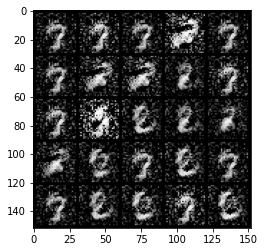

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 131 : Gen loss : 2.0019 || Disc loss : 0.3263 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 132 : Gen loss : 1.9945 || Disc loss : 0.3281 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 133 : Gen loss : 1.9642 || Disc loss : 0.3325 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 134 : Gen loss : 2.0416 || Disc loss : 0.2921 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 135 : Gen loss : 2.1211 || Disc loss : 0.2910 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 136 : Gen loss : 2.1328 || Disc loss : 0.3100 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 137 : Gen loss : 2.1924 || Disc loss : 0.3124 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 138 : Gen loss : 2.1101 || Disc loss : 0.2906 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 139 : Gen loss : 2.1926 || Disc loss : 0.2703 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 140 : Gen loss : 2.1287 || Disc loss : 0.2777 


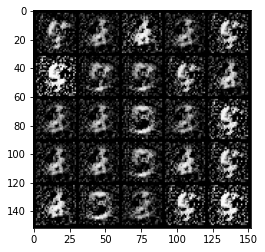

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 141 : Gen loss : 2.3794 || Disc loss : 0.2456 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 142 : Gen loss : 2.1020 || Disc loss : 0.3254 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 143 : Gen loss : 2.0840 || Disc loss : 0.2765 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 144 : Gen loss : 2.1218 || Disc loss : 0.2715 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 145 : Gen loss : 2.1441 || Disc loss : 0.2884 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 146 : Gen loss : 2.2199 || Disc loss : 0.3123 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 147 : Gen loss : 2.0534 || Disc loss : 0.3306 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 148 : Gen loss : 2.0381 || Disc loss : 0.3058 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 149 : Gen loss : 2.0276 || Disc loss : 0.2885 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 150 : Gen loss : 1.9319 || Disc loss : 0.3210 


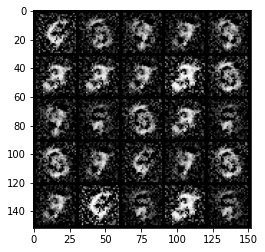

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 151 : Gen loss : 2.0689 || Disc loss : 0.2870 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 152 : Gen loss : 2.0491 || Disc loss : 0.3331 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 153 : Gen loss : 2.0283 || Disc loss : 0.3042 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 154 : Gen loss : 2.2137 || Disc loss : 0.3062 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 155 : Gen loss : 2.0900 || Disc loss : 0.2893 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 156 : Gen loss : 2.1173 || Disc loss : 0.2842 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 157 : Gen loss : 2.1031 || Disc loss : 0.2863 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 158 : Gen loss : 2.1372 || Disc loss : 0.2940 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 159 : Gen loss : 2.2758 || Disc loss : 0.2795 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 160 : Gen loss : 2.2512 || Disc loss : 0.2686 


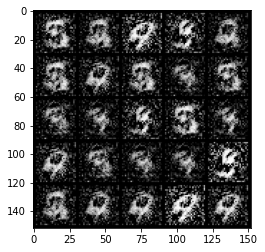

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 161 : Gen loss : 2.1427 || Disc loss : 0.3031 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 162 : Gen loss : 2.0806 || Disc loss : 0.2891 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 163 : Gen loss : 2.0332 || Disc loss : 0.3125 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 164 : Gen loss : 2.0530 || Disc loss : 0.2952 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 165 : Gen loss : 2.1817 || Disc loss : 0.2674 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 166 : Gen loss : 2.1592 || Disc loss : 0.2958 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 167 : Gen loss : 2.1889 || Disc loss : 0.2686 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 168 : Gen loss : 2.1840 || Disc loss : 0.3223 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 169 : Gen loss : 2.1542 || Disc loss : 0.2963 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 170 : Gen loss : 2.2589 || Disc loss : 0.2715 


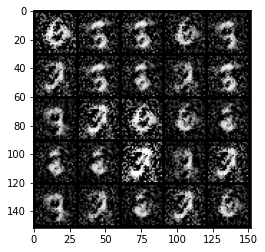

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 171 : Gen loss : 2.1397 || Disc loss : 0.2768 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 172 : Gen loss : 2.1523 || Disc loss : 0.2739 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 173 : Gen loss : 2.2972 || Disc loss : 0.2784 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 174 : Gen loss : 2.2364 || Disc loss : 0.2720 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 175 : Gen loss : 2.3876 || Disc loss : 0.2629 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 176 : Gen loss : 2.2310 || Disc loss : 0.2980 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 177 : Gen loss : 2.3399 || Disc loss : 0.2615 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 178 : Gen loss : 2.2791 || Disc loss : 0.2561 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 179 : Gen loss : 2.3965 || Disc loss : 0.2346 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 180 : Gen loss : 2.3699 || Disc loss : 0.2606 


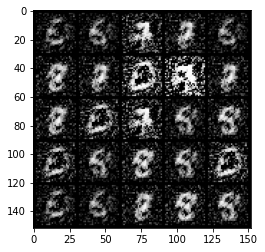

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 181 : Gen loss : 2.3774 || Disc loss : 0.2532 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 182 : Gen loss : 2.3416 || Disc loss : 0.2529 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 183 : Gen loss : 2.2482 || Disc loss : 0.2537 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 184 : Gen loss : 2.4715 || Disc loss : 0.2267 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 185 : Gen loss : 2.4244 || Disc loss : 0.2306 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 186 : Gen loss : 2.3935 || Disc loss : 0.2443 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 187 : Gen loss : 2.3652 || Disc loss : 0.2537 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 188 : Gen loss : 2.4335 || Disc loss : 0.2372 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 189 : Gen loss : 2.4524 || Disc loss : 0.2217 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 190 : Gen loss : 2.6968 || Disc loss : 0.2409 


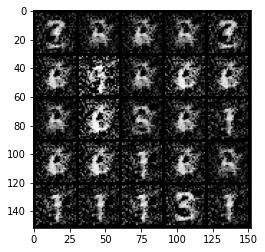

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 191 : Gen loss : 2.3117 || Disc loss : 0.2586 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 192 : Gen loss : 2.3480 || Disc loss : 0.2195 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 193 : Gen loss : 2.3439 || Disc loss : 0.2551 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 194 : Gen loss : 2.4321 || Disc loss : 0.2549 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 195 : Gen loss : 2.4176 || Disc loss : 0.2584 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 196 : Gen loss : 2.4098 || Disc loss : 0.2302 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 197 : Gen loss : 2.4975 || Disc loss : 0.2245 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 198 : Gen loss : 2.5245 || Disc loss : 0.2482 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 199 : Gen loss : 2.5828 || Disc loss : 0.2517 


  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



 Epoch 200 : Gen loss : 2.4242 || Disc loss : 0.2247 


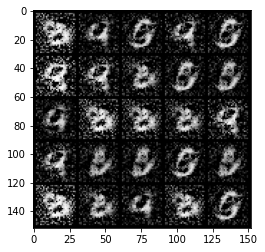

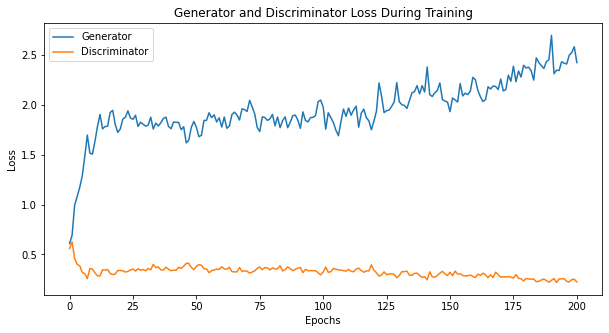

In [ ]:
# Training : 
training_gan(dataloader_mnist, generator, discriminator, optimizer_generator, optimizer_discriminator, nb_epochs)

In [ ]:
class Generator(nn.Module):

    def __init__(self, latent_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()

        self.latent_dim = latent_dim

        def block(in_feat, out_feat, normalize=True):
                layers = [nn.Linear(in_feat, out_feat)]
                if normalize:
                    layers.append(nn.BatchNorm1d(out_feat, 0.8))
                layers.append(nn.LeakyReLU(0.2, inplace=True))
                return layers

        self.gen = nn.Sequential(
                *block(latent_dim, hidden_dim), #, normalize=False),
                *block(hidden_dim, hidden_dim*2),
                *block(hidden_dim*2, hidden_dim*4),
                *block(hidden_dim*4, hidden_dim*8),
                nn.Linear(hidden_dim*8, im_dim),
                nn.Sigmoid()
            )

    def forward(self, noise):
        return self.gen(noise)

    def generate(self, nb_samples):
        noise = torch.rand(nb_samples,self.latent_dim, device=device)
        return self.forward(noise)

In [ ]:
# Setting parameters :
im_dim = 784
hidden_dim = 128
latent_dim = 64

nb_epochs = 201
lr = 0.00001

# Creation of the model & their optimizers : 
generator = Generator(latent_dim, im_dim, hidden_dim).to(device)
discriminator = Discriminator(im_dim, hidden_dim).to(device)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 0 : Gen loss : 2.3688 || Disc loss : 0.3101 


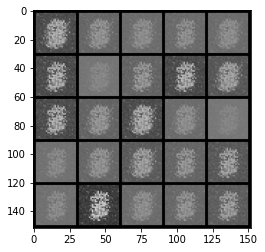

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 1 : Gen loss : 4.6259 || Disc loss : 0.1930 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 2 : Gen loss : 2.0828 || Disc loss : 0.3349 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 3 : Gen loss : 1.6764 || Disc loss : 0.2516 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 4 : Gen loss : 1.8977 || Disc loss : 0.1842 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 5 : Gen loss : 2.2903 || Disc loss : 0.1250 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 6 : Gen loss : 2.6668 || Disc loss : 0.0841 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 7 : Gen loss : 3.0523 || Disc loss : 0.0595 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 8 : Gen loss : 3.2683 || Disc loss : 0.0503 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 9 : Gen loss : 3.3822 || Disc loss : 0.0426 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 10 : Gen loss : 3.5076 || Disc loss : 0.0388 


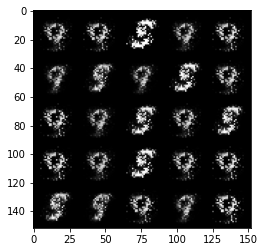

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 11 : Gen loss : 3.7961 || Disc loss : 0.0355 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 12 : Gen loss : 4.2121 || Disc loss : 0.0222 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 13 : Gen loss : 4.2013 || Disc loss : 0.0244 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 14 : Gen loss : 4.4213 || Disc loss : 0.0237 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 15 : Gen loss : 4.6235 || Disc loss : 0.0244 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 16 : Gen loss : 4.7633 || Disc loss : 0.0217 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 17 : Gen loss : 4.8957 || Disc loss : 0.0176 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 18 : Gen loss : 4.6639 || Disc loss : 0.0197 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 19 : Gen loss : 4.9330 || Disc loss : 0.0176 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 20 : Gen loss : 5.2294 || Disc loss : 0.0135 


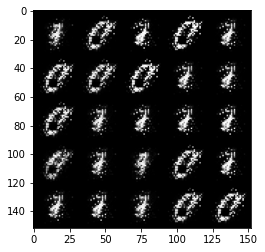

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 21 : Gen loss : 5.4492 || Disc loss : 0.0111 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 22 : Gen loss : 5.3404 || Disc loss : 0.0116 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 23 : Gen loss : 5.5597 || Disc loss : 0.0120 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 24 : Gen loss : 5.3354 || Disc loss : 0.0122 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 25 : Gen loss : 5.3769 || Disc loss : 0.0112 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 26 : Gen loss : 5.6082 || Disc loss : 0.0120 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 27 : Gen loss : 5.6421 || Disc loss : 0.0094 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 28 : Gen loss : 5.4771 || Disc loss : 0.0100 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 29 : Gen loss : 5.8228 || Disc loss : 0.0098 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 30 : Gen loss : 5.9451 || Disc loss : 0.0087 


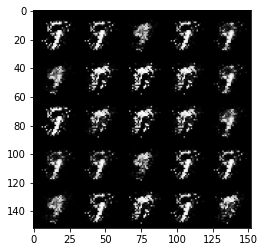

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 31 : Gen loss : 5.6941 || Disc loss : 0.0094 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 32 : Gen loss : 5.7547 || Disc loss : 0.0101 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 33 : Gen loss : 5.5335 || Disc loss : 0.0125 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 34 : Gen loss : 5.5500 || Disc loss : 0.0115 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 35 : Gen loss : 5.5833 || Disc loss : 0.0115 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 36 : Gen loss : 5.7634 || Disc loss : 0.0100 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 37 : Gen loss : 6.0503 || Disc loss : 0.0088 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 38 : Gen loss : 5.9325 || Disc loss : 0.0101 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 39 : Gen loss : 6.3141 || Disc loss : 0.0087 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 40 : Gen loss : 6.1494 || Disc loss : 0.0098 


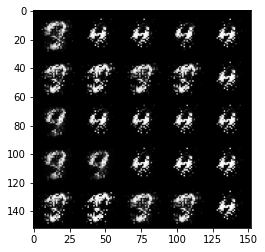

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 41 : Gen loss : 6.6870 || Disc loss : 0.0181 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 42 : Gen loss : 5.7123 || Disc loss : 0.0173 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 43 : Gen loss : 6.4237 || Disc loss : 0.0133 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 44 : Gen loss : 6.4094 || Disc loss : 0.0145 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 45 : Gen loss : 5.5108 || Disc loss : 0.0205 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 46 : Gen loss : 5.2619 || Disc loss : 0.0224 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 47 : Gen loss : 4.9361 || Disc loss : 0.0276 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 48 : Gen loss : 5.5255 || Disc loss : 0.0197 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 49 : Gen loss : 5.4425 || Disc loss : 0.0179 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 50 : Gen loss : 5.6469 || Disc loss : 0.0209 


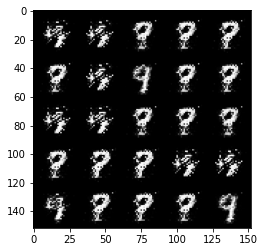

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 51 : Gen loss : 5.8125 || Disc loss : 0.0186 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 52 : Gen loss : 5.5593 || Disc loss : 0.0195 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 53 : Gen loss : 5.6636 || Disc loss : 0.0173 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 54 : Gen loss : 5.9219 || Disc loss : 0.0113 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 55 : Gen loss : 6.0108 || Disc loss : 0.0107 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 56 : Gen loss : 5.9983 || Disc loss : 0.0112 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 57 : Gen loss : 6.4854 || Disc loss : 0.0126 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 58 : Gen loss : 6.4477 || Disc loss : 0.0160 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 59 : Gen loss : 5.8771 || Disc loss : 0.0111 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 60 : Gen loss : 6.1067 || Disc loss : 0.0101 


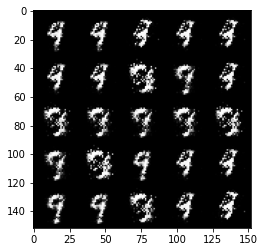

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 61 : Gen loss : 6.0509 || Disc loss : 0.0156 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 62 : Gen loss : 5.9445 || Disc loss : 0.0187 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 63 : Gen loss : 5.8343 || Disc loss : 0.0143 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 64 : Gen loss : 5.6587 || Disc loss : 0.0182 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 65 : Gen loss : 5.6586 || Disc loss : 0.0190 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 66 : Gen loss : 5.7907 || Disc loss : 0.0162 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 67 : Gen loss : 5.7828 || Disc loss : 0.0154 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 68 : Gen loss : 5.5821 || Disc loss : 0.0175 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 69 : Gen loss : 5.6918 || Disc loss : 0.0177 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 70 : Gen loss : 5.4190 || Disc loss : 0.0200 


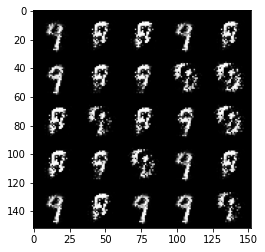

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 71 : Gen loss : 5.6762 || Disc loss : 0.0161 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 72 : Gen loss : 5.8727 || Disc loss : 0.0160 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 73 : Gen loss : 5.7855 || Disc loss : 0.0147 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 74 : Gen loss : 6.5485 || Disc loss : 0.0086 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 75 : Gen loss : 6.1141 || Disc loss : 0.0084 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 76 : Gen loss : 6.0998 || Disc loss : 0.0115 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 77 : Gen loss : 6.3082 || Disc loss : 0.0099 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 78 : Gen loss : 6.2581 || Disc loss : 0.0085 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 79 : Gen loss : 6.6792 || Disc loss : 0.0091 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 80 : Gen loss : 6.2801 || Disc loss : 0.0107 


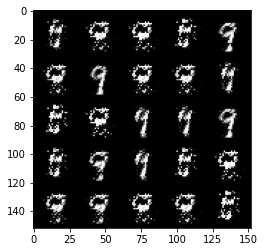

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 81 : Gen loss : 6.2194 || Disc loss : 0.0086 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 82 : Gen loss : 6.3743 || Disc loss : 0.0090 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 83 : Gen loss : 6.5918 || Disc loss : 0.0071 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 84 : Gen loss : 7.2782 || Disc loss : 0.0070 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 85 : Gen loss : 6.6271 || Disc loss : 0.0071 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 86 : Gen loss : 6.8998 || Disc loss : 0.0089 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 87 : Gen loss : 6.2092 || Disc loss : 0.0117 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 88 : Gen loss : 6.2026 || Disc loss : 0.0104 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 89 : Gen loss : 6.5913 || Disc loss : 0.0113 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 90 : Gen loss : 6.8811 || Disc loss : 0.0111 


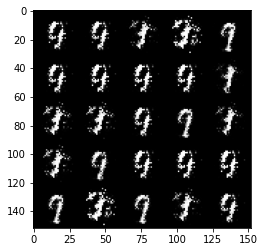

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 91 : Gen loss : 6.0059 || Disc loss : 0.0132 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 92 : Gen loss : 6.2466 || Disc loss : 0.0249 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 93 : Gen loss : 5.8018 || Disc loss : 0.0249 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 94 : Gen loss : 5.9506 || Disc loss : 0.0125 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 95 : Gen loss : 6.2049 || Disc loss : 0.0116 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 96 : Gen loss : 6.4303 || Disc loss : 0.0091 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 97 : Gen loss : 6.6486 || Disc loss : 0.0084 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 98 : Gen loss : 6.7825 || Disc loss : 0.0064 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 99 : Gen loss : 6.7004 || Disc loss : 0.0065 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 100 : Gen loss : 6.9691 || Disc loss : 0.0076 


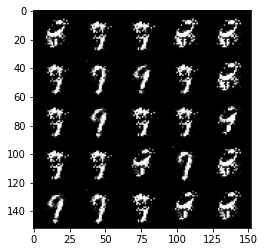

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 101 : Gen loss : 7.2659 || Disc loss : 0.0098 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 102 : Gen loss : 6.7835 || Disc loss : 0.0261 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 103 : Gen loss : 6.5713 || Disc loss : 0.0187 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 104 : Gen loss : 6.7071 || Disc loss : 0.0153 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 105 : Gen loss : 6.2769 || Disc loss : 0.0139 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 106 : Gen loss : 5.9580 || Disc loss : 0.0156 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 107 : Gen loss : 6.0884 || Disc loss : 0.0170 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 108 : Gen loss : 6.4528 || Disc loss : 0.0127 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 109 : Gen loss : 6.2717 || Disc loss : 0.0098 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 110 : Gen loss : 6.3708 || Disc loss : 0.0129 


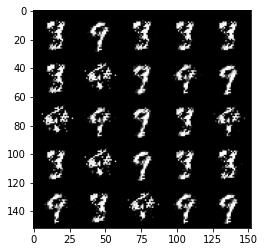

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 111 : Gen loss : 6.3865 || Disc loss : 0.0140 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 112 : Gen loss : 6.2099 || Disc loss : 0.0171 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 113 : Gen loss : 6.3680 || Disc loss : 0.0134 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 114 : Gen loss : 6.8003 || Disc loss : 0.0114 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 115 : Gen loss : 6.5498 || Disc loss : 0.0093 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 116 : Gen loss : 6.4090 || Disc loss : 0.0107 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 117 : Gen loss : 6.5070 || Disc loss : 0.0122 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 118 : Gen loss : 6.4937 || Disc loss : 0.0110 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 119 : Gen loss : 6.6270 || Disc loss : 0.0133 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 120 : Gen loss : 6.8049 || Disc loss : 0.0106 


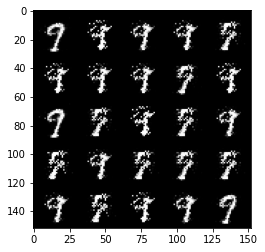

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 121 : Gen loss : 6.4874 || Disc loss : 0.0106 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 122 : Gen loss : 6.2776 || Disc loss : 0.0141 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 123 : Gen loss : 7.0461 || Disc loss : 0.0150 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 124 : Gen loss : 7.0948 || Disc loss : 0.0213 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 125 : Gen loss : 6.1889 || Disc loss : 0.0192 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 126 : Gen loss : 6.1197 || Disc loss : 0.0153 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 127 : Gen loss : 6.7753 || Disc loss : 0.0111 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 128 : Gen loss : 6.7743 || Disc loss : 0.0104 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 129 : Gen loss : 7.0526 || Disc loss : 0.0091 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 130 : Gen loss : 7.1465 || Disc loss : 0.0079 


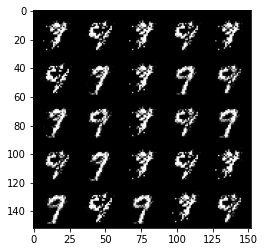

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 131 : Gen loss : 6.8438 || Disc loss : 0.0158 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 132 : Gen loss : 6.2553 || Disc loss : 0.0236 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 133 : Gen loss : 6.0973 || Disc loss : 0.0203 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 134 : Gen loss : 6.5384 || Disc loss : 0.0190 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 135 : Gen loss : 6.5761 || Disc loss : 0.0123 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 136 : Gen loss : 6.6772 || Disc loss : 0.0095 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 137 : Gen loss : 6.7867 || Disc loss : 0.0099 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 138 : Gen loss : 6.8299 || Disc loss : 0.0114 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 139 : Gen loss : 6.7993 || Disc loss : 0.0160 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 140 : Gen loss : 6.1309 || Disc loss : 0.0183 


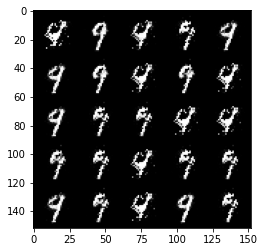

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 141 : Gen loss : 6.5269 || Disc loss : 0.0143 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 142 : Gen loss : 6.5528 || Disc loss : 0.0104 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 143 : Gen loss : 6.7736 || Disc loss : 0.0148 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 144 : Gen loss : 6.5075 || Disc loss : 0.0144 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 145 : Gen loss : 6.3570 || Disc loss : 0.0253 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 146 : Gen loss : 5.9661 || Disc loss : 0.0205 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 147 : Gen loss : 6.3622 || Disc loss : 0.0164 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 148 : Gen loss : 8.1740 || Disc loss : 0.0167 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 149 : Gen loss : 7.7437 || Disc loss : 0.0213 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 150 : Gen loss : 6.7498 || Disc loss : 0.0227 


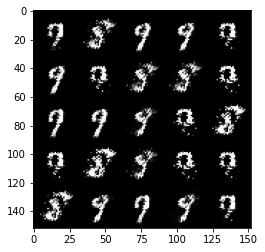

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 151 : Gen loss : 6.2686 || Disc loss : 0.0183 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 152 : Gen loss : 6.2560 || Disc loss : 0.0174 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 153 : Gen loss : 6.2963 || Disc loss : 0.0187 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 154 : Gen loss : 5.9536 || Disc loss : 0.0174 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 155 : Gen loss : 6.6808 || Disc loss : 0.0101 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 156 : Gen loss : 6.8181 || Disc loss : 0.0118 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 157 : Gen loss : 6.7788 || Disc loss : 0.0135 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 158 : Gen loss : 6.6127 || Disc loss : 0.0118 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 159 : Gen loss : 6.5611 || Disc loss : 0.0112 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 160 : Gen loss : 6.5123 || Disc loss : 0.0140 


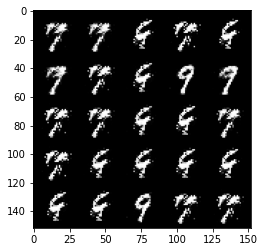

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 161 : Gen loss : 6.2024 || Disc loss : 0.0181 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 162 : Gen loss : 5.9891 || Disc loss : 0.0185 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 163 : Gen loss : 6.5086 || Disc loss : 0.0124 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 164 : Gen loss : 6.5580 || Disc loss : 0.0153 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 165 : Gen loss : 7.3189 || Disc loss : 0.0124 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 166 : Gen loss : 6.4214 || Disc loss : 0.0146 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 167 : Gen loss : 6.1385 || Disc loss : 0.0146 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 168 : Gen loss : 6.3837 || Disc loss : 0.0141 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 169 : Gen loss : 6.3862 || Disc loss : 0.0192 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 170 : Gen loss : 5.9548 || Disc loss : 0.0295 


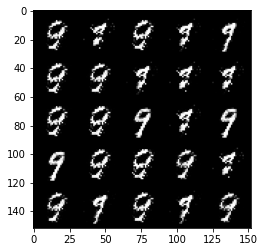

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 171 : Gen loss : 6.0570 || Disc loss : 0.0234 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 172 : Gen loss : 6.2309 || Disc loss : 0.0245 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 173 : Gen loss : 6.1416 || Disc loss : 0.0247 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 174 : Gen loss : 6.2633 || Disc loss : 0.0184 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 175 : Gen loss : 6.4025 || Disc loss : 0.0169 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 176 : Gen loss : 6.2504 || Disc loss : 0.0146 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 177 : Gen loss : 6.6179 || Disc loss : 0.0200 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 178 : Gen loss : 6.6238 || Disc loss : 0.0204 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 179 : Gen loss : 6.7909 || Disc loss : 0.0232 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 180 : Gen loss : 6.2030 || Disc loss : 0.0306 


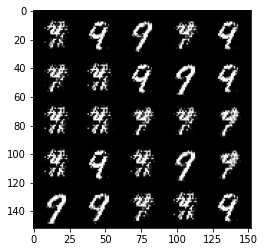

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 181 : Gen loss : 5.5254 || Disc loss : 0.0311 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 182 : Gen loss : 6.1689 || Disc loss : 0.0197 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 183 : Gen loss : 6.3973 || Disc loss : 0.0178 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 184 : Gen loss : 6.2120 || Disc loss : 0.0329 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 185 : Gen loss : 6.0132 || Disc loss : 0.0282 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 186 : Gen loss : 6.1865 || Disc loss : 0.0300 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 187 : Gen loss : 6.3152 || Disc loss : 0.0196 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 188 : Gen loss : 6.1516 || Disc loss : 0.0252 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 189 : Gen loss : 6.1459 || Disc loss : 0.0379 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 190 : Gen loss : 6.2604 || Disc loss : 0.0215 


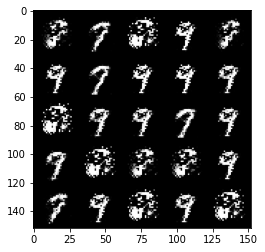

  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 191 : Gen loss : 6.8923 || Disc loss : 0.0144 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 192 : Gen loss : 7.3970 || Disc loss : 0.0134 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 193 : Gen loss : 6.8283 || Disc loss : 0.0217 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 194 : Gen loss : 5.7733 || Disc loss : 0.0280 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 195 : Gen loss : 5.7111 || Disc loss : 0.0239 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 196 : Gen loss : 6.3546 || Disc loss : 0.0411 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 197 : Gen loss : 5.7718 || Disc loss : 0.0248 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 198 : Gen loss : 6.0917 || Disc loss : 0.0194 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 199 : Gen loss : 6.8128 || Disc loss : 0.0192 


  0%|          | 0/469 [00:00<?, ?it/s]


 Epoch 200 : Gen loss : 6.2702 || Disc loss : 0.0287 


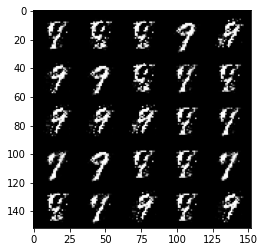

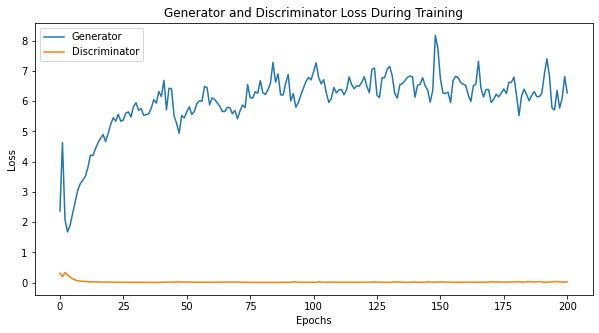

In [ ]:
# Training : 
training_gan(dataloader_mnist, generator, discriminator, optimizer_generator, optimizer_discriminator, nb_epochs)

## StackedMNIST dataset  

StackedMNIST dataset contains images made by stacking $3$ random images from MNIST along the $3$ color channels. We then obtain a dataset with a high number of modes : $1000$ modes. 

In [ ]:
from PIL import Image

In [ ]:
# Implementation taken from : https://github.com/NVlabs/VAEBM/blob/main/datasets.py 

class StackedMNIST(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None,
                 download=False):
        super(StackedMNIST, self).__init__(root=root, train=train, transform=transform,
                                           target_transform=target_transform, download=download)

        index1 = np.hstack([np.random.permutation(len(self.data)), np.random.permutation(len(self.data))])
        index2 = np.hstack([np.random.permutation(len(self.data)), np.random.permutation(len(self.data))])
        index3 = np.hstack([np.random.permutation(len(self.data)), np.random.permutation(len(self.data))])
        self.num_images = 2 * len(self.data)

        self.index = []
        for i in range(self.num_images):
            self.index.append((index1[i], index2[i], index3[i]))

    def __len__(self):
        return self.num_images

    def __getitem__(self, index):
        img = np.zeros((28, 28, 3), dtype=np.uint8)
        target = 0
        for i in range(3):
            img_, target_ = self.data[self.index[index][i]], int(self.targets[self.index[index][i]])
            img[:, :, i] = img_
            target += target_ * 10 ** (2 - i)

        img = Image.fromarray(img, mode="RGB")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

In [ ]:
batch_size = 128
dataset_stacked_mnist = StackedMNIST('.',download=True,transform=transforms.ToTensor())
dataloader_stacked_mnist =  DataLoader(dataset=dataset_stacked_mnist, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./StackedMNIST/raw/train-images-idx3-ubyte.gz to ./StackedMNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./StackedMNIST/raw/train-labels-idx1-ubyte.gz to ./StackedMNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./StackedMNIST/raw/t10k-images-idx3-ubyte.gz to ./StackedMNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./StackedMNIST/raw/t10k-labels-idx1-ubyte.gz to ./StackedMNIST/raw



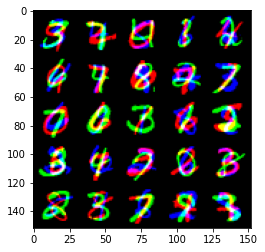

In [ ]:
images, _ = next(iter(dataloader_stacked_mnist))
show_tensor_images(images, size=(3, 28, 28))